<h1>Sieci neuronowe - ćwiczenie 3</h1>

In [1]:
!pip install ucimlrepo


[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

<h3>Przygotowanie danych na podstawie poprzedniego ćwiczenia</h3>

In [3]:
# original code from https://archive.ics.uci.edu/dataset/45/heart+disease
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
heart_data = heart_disease.data.original

In [4]:
df: pd.DataFrame = heart_data

# repearing of the inbalnace in classification and removing null values
df["num"] = df["num"].replace([2, 3, 4], 1) #change classes to binary classification
print(df["num"].value_counts())

#get null values of ca and remove them
null_idx = df[df["ca"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

#get null values of thel and remove them
null_idx = df[df["thal"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

# balance classes to same amount 138
random_idx = df.query("num == 0").sample(df["num"].value_counts()[0] - df["num"].value_counts()[1]).index 
df = df.drop(random_idx)
df = df.reset_index(drop=True)
print(df["num"].value_counts())

df_without_num = df.loc[:, df.columns != "num"]
std_features = (df_without_num - df_without_num.mean() )/ df_without_num.std() #(value-mean)/variance

result = std_features
result["heart_disease"] = df["num"]

# data not standarized 4. Danych znormalizowanych i nieznormalizowanych
n_std_result = df_without_num
n_std_result["heart_disease"] = df["num"]

result

num
0    164
1    139
Name: count, dtype: int64
Index([166, 192, 287, 302], dtype='int64')
num
0    161
1    138
Name: count, dtype: int64
Index([87, 264], dtype='int64')
num
0    160
1    137
Name: count, dtype: int64
num
0    137
1    137
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,0.940780,0.658004,-2.299921,0.737460,-0.277036,2.379535,0.992754,0.030178,-0.721330,1.034423,2.261433,-0.724268,0.605067,0
1,1.391237,0.658004,0.835295,1.581034,0.741990,-0.418716,0.992754,-1.778605,1.381269,0.354323,0.635100,2.442477,-0.934763,1
2,1.391237,0.658004,0.835295,-0.668496,-0.353944,-0.418716,0.992754,-0.874213,1.381269,1.289461,0.635100,1.386896,1.118344,1
3,-1.987188,0.658004,-0.209777,-0.106114,0.049822,-0.418716,-1.014734,1.623629,-0.721330,2.054574,2.261433,-0.724268,-0.934763,0
4,-1.536731,-1.514202,-1.254849,-0.106114,-0.834616,-0.418716,0.992754,0.977635,-0.721330,0.269310,-0.991232,-0.724268,-0.934763,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,0.265095,-1.514202,0.835295,0.456269,-0.123221,-0.418716,-1.014734,-1.132611,1.381269,-0.750841,0.635100,-0.724268,1.118344,1
270,-1.086275,0.658004,-2.299921,-1.230879,0.318998,-0.418716,-1.014734,-0.745015,-0.721330,0.099285,0.635100,-0.724268,1.118344,1
271,1.503851,0.658004,0.835295,0.681222,-1.046112,2.379535,-1.014734,-0.357418,-0.721330,1.969562,0.635100,1.386896,1.118344,1
272,0.265095,0.658004,0.835295,-0.106114,-2.238181,-0.418716,-1.014734,-1.477141,1.381269,0.099285,0.635100,0.331314,1.118344,1


In [5]:
def train_test_split(features, targets, percentage):
    choices = np.random.choice(range(features.shape[0]), size=(int(features.shape[0] * percentage/100),), replace=False) 
    split = np.zeros(features.shape[0], dtype=bool)
    split[choices] = True

    return features[split], targets[split], features[~split], targets[~split]

In [6]:
features = result.loc[:, result.columns != "heart_disease"].to_numpy()
targets = result["heart_disease"].to_numpy()

x_train, y_train, x_test, y_test = train_test_split(features, targets, 70)

<h1>Przygotowanie modelu</h1>

In [7]:
def sigmoid(n):
    return 1 / (1 + np.exp(-n))


def sigmoid_der(n):
    return sigmoid(n) * (1 - sigmoid(n))

In [8]:
class Neuron:
    _weights: np.ndarray
    _bias: float
    _cache_x: np.ndarray
    _err: np.ndarray 

    def init_weights(self, size: int, std_dev: float):
        self._weights = np.random.normal(scale=std_dev, size=size) # initialize weights 
        self._bias = np.random.normal(scale=std_dev) #initialize bias 

    def forward(self, x: np.ndarray) -> np.ndarray:
       self._cache_x = x
       return sigmoid(np.dot(x, self._weights) + self._bias)
    
    def backward(self, error: np.ndarray):
       self._err = error * sigmoid_der(np.dot(self._cache_x, self._weights) + self._bias) 
       return self._err
    
    def backward_weights(self, error: np.ndarray, next_weights: np.ndarray):
       error = error.T @ next_weights
       self._err = error * sigmoid_der(np.dot(self._cache_x, self._weights) + self._bias) 
       return self._err

    def update_weights(self, learning_rate: float):
      self._weights = self._weights - learning_rate * np.dot(self._cache_x.T, self._err)
      self._bias = self._bias - learning_rate * np.sum(self._err)

    def get_weights(self):
       return self._weights  

    def get_bias(self):
       return self._bias  
    
class MultilayerNetwork:
    def __cross_entropy_loss(self, y, y_pred):
        return -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred), axis=1)

    def __cross_entropy_loss_der(self, y, y_pred):
        return -np.sum(y / y_pred - (1 - y) / (1 - y_pred), axis=1)
    
    def __init__(self, hidden_layers_sizes):
        self._layers: list[list[Neuron]] = []
   
        for index, layer_size in enumerate(hidden_layers_sizes):
            self._layers.append([])
            for _ in range(layer_size):
                self._layers[index].append(Neuron()) 

        # output layer
        self._layers.append([])
        self._layers[-1].append(Neuron())        

    def optimize(self, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, batch_size: int, learning_rate: float, 
                        max_iter: int, std_dev: float, verb = False):
        
        losses = [] 
        weights = []
        biases = []
        losses_test = []

        accuracy = []
        f_score = []
        recalls = []

        curr_size_layer = x_train.shape[1]
      
        for layer in self._layers:
            for neuron in layer:
                neuron.init_weights(curr_size_layer, std_dev) 
            curr_size_layer = len(layer)

        #fix shape of y data to match further calculations
        if len(y_test.shape) == 1:
            y_test = y_test[np.newaxis].T 

        if len(y_train.shape) == 1:
            y_train = y_train[np.newaxis].T

        if batch_size > x_train.shape[0]:
            batch_size = x_train.shape[0]

        for index in range(max_iter): #learn for max_iter      
            shuffle = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[shuffle]
            y_train_shuffled = y_train[shuffle]

            for batch_start_index in range(0, x_train.shape[0], batch_size):
                x_train_batch = x_train_shuffled[batch_start_index:batch_start_index+batch_size] 
                y_train_batch = y_train_shuffled[batch_start_index:batch_start_index+batch_size] 

                pred = self.forward(x_train_batch)
                self.backward(y_train_batch, pred)

                for layer in self._layers:
                    for neuron in layer:
                        neuron.update_weights(learning_rate)
                new_train_batch_loss = np.array([])
                new_train_batch_loss = np.append(new_train_batch_loss, self.__cross_entropy_loss(y_train_batch, pred))
            
            new_train_loss = np.mean(new_train_batch_loss)
            #calculate loss of test data
            test_pred = self.predict(x_test)
            new_test_loss = np.mean(self.__cross_entropy_loss(y_test, test_pred))

            #append to helper lists
            losses.append(new_train_loss)
            weights.append(self.__get_weights())
            biases.append(self.__get_biases())
            losses_test.append(new_test_loss)

            test_pred[test_pred >= 0.5] = 1
            test_pred[test_pred < 0.5] = 0

            #calculate scores for each iteration
            accuracy.append(metrics.accuracy_score(y_test, test_pred))
            f_score.append(metrics.f1_score(y_test, test_pred))
            recalls.append(metrics.recall_score(y_test, test_pred))

        if verb:
         #plot results
            plt.plot(np.arange(len(losses)), losses, label="Train Loss")
            plt.plot(np.arange(len(losses)), losses_test, label="Test loss")
            plt.plot(np.convolve(losses, np.ones(batch_size)/batch_size, mode='valid'), label="Train loss smooth")
            plt.legend()
            plt.show()

        #print final weight, bias, loss and scores
            print("Weights: ", self.__get_weights())
            print("Bias: ", self.__get_biases())
         
        print("Train loss: ", losses[-1])
        print("Test loss: ", losses_test[-1])

        print("Scores")
        print("Accuracy: ", accuracy[-1])
        print("F_score: ", f_score[-1])
        print("Recall: ", recalls[-1])
        return losses, weights, biases, losses_test, accuracy, f_score, recalls  

    def forward(self, x: np.ndarray) -> float:
        for layer in self._layers:
            x = np.array([neuron.forward(x) for neuron in layer]).T
        return x

    def backward(self, y_train: np.ndarray, y_pred: np.ndarray) -> list[list[np.ndarray[float]]]:
        err = np.array([out_neuron.backward(self.__cross_entropy_loss_der(y_train, y_pred)) for out_neuron in self._layers[-1]])
        next_weights = np.array([out_neuron.get_weights() for out_neuron in self._layers[-1]]).T

        for layer in reversed(self._layers[:-1]):
            err = np.array([neuron.backward_weights(err, next_weights[neuron_index]) for neuron_index, neuron in enumerate(layer)])
            next_weights = np.array([neuron.get_weights() for neuron in layer]).T
         

    def predict(self, x_test: np.ndarray) -> np.ndarray:
        return self.forward(x_test) 
    
    def __get_weights(self) -> []:
        weights = []
        for layer in self._layers:
            weights.append([neuron.get_weights() for neuron in layer])     
        return weights
    
    def __get_biases(self) -> []:
        biases = []
        for layer in self._layers:
            biases.append([neuron.get_bias() for neuron in layer])     
        return biases 
   

In [9]:
#1. Różnej wymiarowości warstwy ukrytej
hidden1 = (4, 3)
hidden2 = (20, 10)
hidden3 = (100, 50)

#2. Różnej wartości współczynnika uczenia
learning1 = 0.001
learning2 = 0.01

#3. Różnych odchyleń standardowych przy inicjalizacji wag
std_dev1 = 0.8
std_dev2 = 0.3

#5. Różnej liczby warstw
hidden4 = (20,)
hidden5 = (20, 20)
hidden6 = (20, 20, 20)

max_iter = 500

<p>1. Różnej wymiarowości warstwy ukrytej</p>

In [10]:
ex1 = MultilayerNetwork(hidden1)
ex2 = MultilayerNetwork(hidden2)
ex3 = MultilayerNetwork(hidden3)

r1 = ex1.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.4)
r2 = ex2.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.4)
r3 = ex3.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.4)

Train loss:  0.6396728517280297
Test loss:  0.5309083150631737
Scores
Accuracy:  0.8433734939759037
F_score:  0.8470588235294119
Recall:  0.8372093023255814
Train loss:  0.7272749837058788
Test loss:  0.36411428440751065
Scores
Accuracy:  0.8313253012048193
F_score:  0.8372093023255814
Recall:  0.8372093023255814
Train loss:  0.11064111280881866
Test loss:  0.3566068137096169
Scores
Accuracy:  0.8674698795180723
F_score:  0.8705882352941177
Recall:  0.8604651162790697


<p>2. Różnej wartości współczynnika uczenia</p>

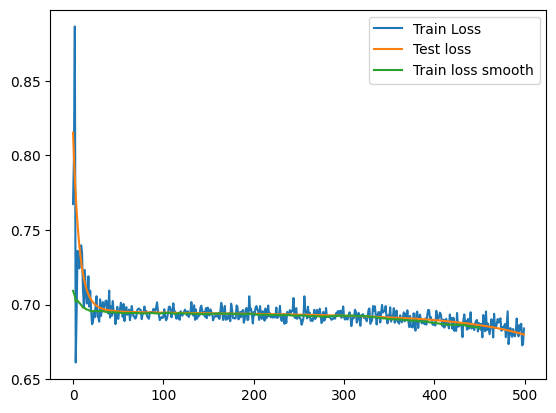

Weights:  [[array([ 0.61155366,  0.03496298, -0.74458027, -0.31359172, -0.60316673,
       -0.4687239 , -0.09111859, -0.31447199, -0.04724093, -0.54453884,
       -0.56890592,  0.56129581, -0.19592251]), array([-0.76037061, -0.10321717, -0.07533876, -0.43995999,  0.01711322,
       -0.08207185,  0.66713951, -0.40273012,  0.25777814, -0.38719817,
        0.63764881,  0.28495847, -0.14624454]), array([-0.16583426, -0.35955375,  0.47788953, -0.07715087, -0.23765394,
        0.41167623,  0.23017661,  0.32205485,  0.32901591,  0.25958388,
       -0.64386834, -0.10981143,  0.07682652]), array([ 0.57914452,  0.11736877,  0.87335767, -0.49533634,  0.18579979,
       -0.56071476, -0.13015901, -0.17515517, -0.07155944,  0.49308838,
       -0.00358674,  0.76803292, -0.23400259])], [array([ 0.60428473,  0.20522872,  0.56566636, -0.8975688 ]), array([ 0.37614615, -0.09347212, -0.21517198, -0.27003025]), array([ 0.24513027,  0.29173338, -1.26631075,  0.20254747])], [array([-0.52798968, -0.14055743, 

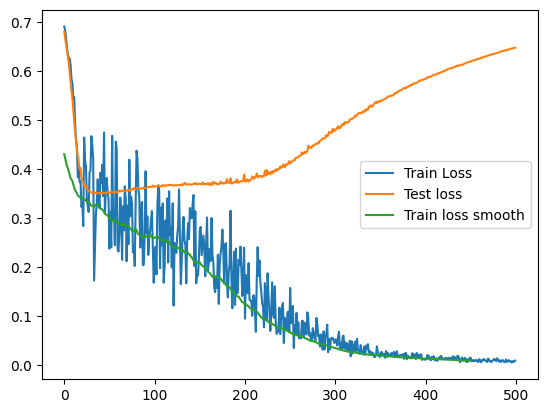

Weights:  [[array([-1.01203104,  0.15605596,  0.14079524,  0.8650145 , -0.46457511,
       -0.25121071,  1.11956582,  0.40032809,  0.20068433,  0.3104899 ,
        0.16067393,  1.48081564,  0.56502294]), array([-0.81692388,  0.89179364, -0.74247555, -0.2129151 , -0.08262655,
       -1.15554124,  0.00457478,  0.34180852, -0.90608527, -0.49659152,
       -0.22435009, -0.21693734, -0.56375407]), array([ 1.27959213, -0.93895078,  0.58270955, -0.14089205, -0.05464316,
        1.22467605,  0.20362829, -0.51768867, -0.54330484, -0.16592057,
        0.37585738,  0.07786844,  0.80395522]), array([ 0.43783553, -0.18277339, -0.35512918, -0.40589242,  0.14384208,
       -0.36646036, -0.46869272, -0.67190405,  0.23677767, -0.11235537,
       -0.22144374,  0.02927393, -0.14186169]), array([ 0.37952429,  0.97133886, -0.108466  ,  0.30173108,  0.02311255,
       -0.5881602 ,  0.30132482,  0.03944742,  0.3602904 ,  0.71534472,
        0.89315202, -0.42755293,  0.18680136]), array([ 0.79296465, -0.85313

In [11]:
ex4 = MultilayerNetwork(hidden2)
ex5 = MultilayerNetwork(hidden2)

r4 = ex1.optimize(x_train, y_train, x_test, y_test, 50, learning1, max_iter, 0.4, verb=True)
r5 = ex2.optimize(x_train, y_train, x_test, y_test, 50, learning2, max_iter, 0.4,  verb=True)

<p>3. Różnych odchyleń standardowych przy inicjalizacji wag</p>

In [12]:
ex6 = MultilayerNetwork(hidden2)
ex7 = MultilayerNetwork(hidden2)

r6 = ex1.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, std_dev1)
r7 = ex2.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, std_dev2)

Train loss:  0.4887755719507098
Test loss:  0.42971278984722794
Scores
Accuracy:  0.8313253012048193
F_score:  0.825
Recall:  0.7674418604651163
Train loss:  0.4228120612429768
Test loss:  0.37478752923439185
Scores
Accuracy:  0.8554216867469879
F_score:  0.8571428571428572
Recall:  0.8372093023255814


<p>4. Danych znormalizowanych i nieznormalizowanych</p>

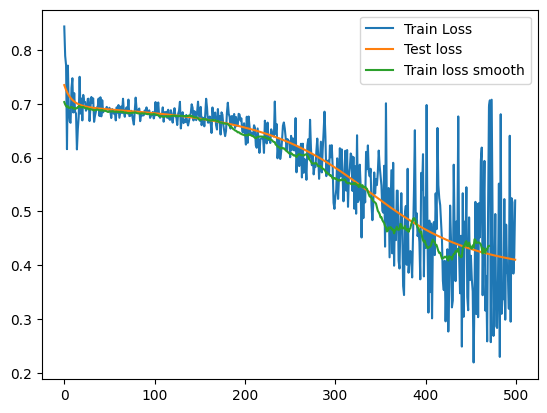

Weights:  [[array([-0.80504054, -0.05356587, -0.31212731,  0.04507451, -0.33305513,
        0.45733534, -0.84060054,  0.36595598,  0.2821585 ,  0.19874302,
        0.24694113, -0.26109311, -0.2196897 ]), array([ 1.04830098,  0.44259735,  0.06977663, -0.22341452, -0.20637428,
        0.23715805,  0.45246022, -0.4890249 ,  0.30441514, -0.54608751,
        0.68822242, -0.33318265,  0.48470289]), array([ 0.40081393, -0.70382412, -0.61786282,  0.0341178 , -0.23642928,
        0.09518566, -0.1272    ,  1.08623602, -0.1204251 , -0.59430561,
       -0.2682353 , -1.4277327 , -1.24427302]), array([ 0.16060231,  0.22455157,  0.65894066, -0.12897642, -0.21881624,
        0.04216556, -0.15922917, -0.47587727,  0.55325972, -0.17392742,
        0.19816705,  0.68802426,  0.82803697])], [array([-0.19362886, -0.15190539, -1.10353724, -0.01699691]), array([ 0.31789453, -0.14963936, -2.44946002,  1.24370627]), array([ 0.4734622 , -1.01037037,  1.61736915, -1.02868042])], [array([ 0.92218637,  2.54561233, 

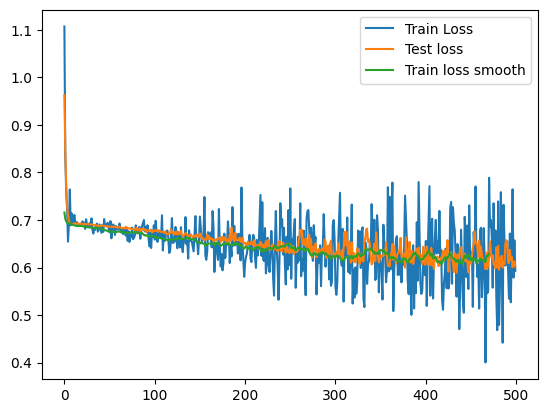

Weights:  [[array([ 0.45246928, -0.22711955,  0.20093285,  0.65340227,  0.23195717,
       -0.35074997, -0.27749209, -1.15954891,  0.56752385,  0.54730981,
        0.53082937,  0.29971946,  0.47771781]), array([ 0.45752675,  0.37420991,  0.05720403, -0.12659816,  0.70582492,
       -0.00306344,  0.14718921,  0.50657985,  0.899911  , -0.30430759,
       -0.21267718, -0.42147729,  0.45601434]), array([-1.00580514, -0.38041073, -0.50600529,  0.45212621,  0.91189523,
        0.50236871,  0.05258998,  0.88896142,  0.72576887,  0.41440592,
        0.09036201, -0.23093014, -0.81978373]), array([-0.87039028, -0.69462381, -0.54723456, -0.90787094,  0.25614509,
        0.68751729,  0.11105289, -0.01924674,  0.00138347, -0.31146281,
       -0.52526164,  0.02523389, -0.56826234]), array([-0.23484286,  0.20594274, -0.62606441, -0.16813774,  0.75191824,
       -0.61267268, -0.77933901,  0.99672556, -0.70845091, -0.49833363,
       -0.76956746,  0.66129594,  0.48992327]), array([ 1.17639394e-01,  3.6

In [13]:
features_n_std = n_std_result.loc[:, result.columns != "heart_disease"].to_numpy()
targets_n_std = n_std_result["heart_disease"].to_numpy()

x_train_n_std, y_train_n_std, x_test_n_std, y_test_n_std = train_test_split(features_n_std, targets_n_std, 70)

ex8 = MultilayerNetwork(hidden2)
ex9 = MultilayerNetwork(hidden2)

r8 = ex1.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.5, verb=True)
r9 = ex2.optimize(x_train_n_std, y_train_n_std, x_test_n_std, y_test_n_std, 30, 0.001, max_iter, 0.5, verb=True)

<p>5. Różnej liczby warstw</p>

In [14]:
ex10 = MultilayerNetwork(hidden4)
ex11 = MultilayerNetwork(hidden5)
ex12 = MultilayerNetwork(hidden6)

r10 = ex1.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.5)
r11 = ex1.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.5)
r12 = ex1.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.5)

Train loss:  0.21005357939843464
Test loss:  0.4069590073940439
Scores
Accuracy:  0.8433734939759037
F_score:  0.8395061728395061
Recall:  0.7906976744186046
Train loss:  0.348112397602423
Test loss:  0.38747779117478476
Scores
Accuracy:  0.8433734939759037
F_score:  0.8470588235294119
Recall:  0.8372093023255814
Train loss:  0.2930378270842262
Test loss:  0.3819280801829279
Scores
Accuracy:  0.8313253012048193
F_score:  0.825
Recall:  0.7674418604651163
